# Vehicle Detection and Tracking
## goal and steps of this project

The goals/steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction and train a classifier.
* Optionally, apply color transform and append binned color features and histograms to HOG feature.
* Note: don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame.
* Estimate a bounding box for vehicles detected.

## Overview
Detect vehicles using HOG + SVM classifier with sliding windows. The overall pipeline is the following:

* Gather and organize the data
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images
* Train a linear SVM classifier on normalized HOG features
* Implement a sliding-window technique and use trained classifier to search for vehicles in images
* Run the above steps on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### 1. Import libraries, set the global parameters and gather the data

In [1]:
# Import Libraries
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread
from skimage.exposure import adjust_gamma
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from moviepy.editor import VideoFileClip
import pickle
import os
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
#Global parameters

color_space = 'RGB' 
orient = 30  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' 
spatial_size = (16, 16) 
hist_bins = 16 
spatial_feat = False 
hist_feat = False 
hog_feat = True 
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
x_start_stop = [0, 1280] 
pct_overlap = 0.7 # sliding window overlap percentage
heatmap_thresh = 33
num_frames = 30 # number of video frames over which to accumulate heatmap
min_ar, max_ar = 0.7, 3.0 
small_bbox_area, close_y_thresh = 80*80, 500
min_bbox_area = 40*40
use_pretrained = True 

In [3]:
non_vehicles = []
vehicles = []

# Non-vehicles
with open('nv_files.txt', 'r') as f:
    lines = f.readlines()

for line in lines:
    line = line[:-1]  # strip trailing newline

    img = cv2.imread(line)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_vehicles.append(img)

# Vehicles
with open('v_files.txt', 'r') as f:
    lines = f.readlines()

for line in lines:
    line = line[:-1]  # strip trailing newline

    img = cv2.imread(line)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vehicles.append(img)

# Save to pickle file
save_dict = {'non_vehicles': np.array(non_vehicles), 'vehicles': np.array(vehicles)}
with open('data.p', 'wb') as f:
    pickle.dump(save_dict, f)

### 2. HOG feature extraction 

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Return HOG features and visualization (optionally)
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
            visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
            visualise=False, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        image_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                feature_image = np.stack((feature_image, feature_image, feature_image), axis=2)  # keep shape
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            image_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            image_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            image_features.append(hog_features)
        features.append(np.concatenate(image_features))
    # Return list of feature vectors
    return features


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            feature_image = np.stack((feature_image, feature_image, feature_image), axis=2)  # keep shape
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

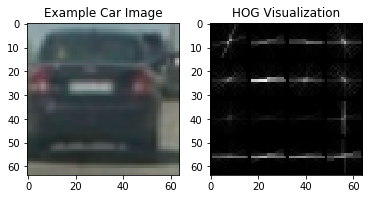

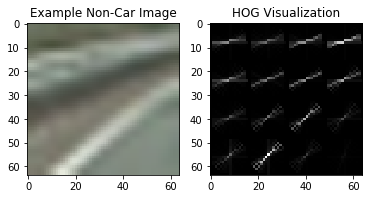

In [8]:
# Vehicle image
image = mpimg.imread('example_images/vehicle.png')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# Non-car image
image = mpimg.imread('example_images/non_vehicle.png')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

### 3. Train a linear SVM

In [10]:
# Train SVM
def train(cars, notcars, svc, X_scaler):
    car_features = extract_features(cars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features, notcar_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler.fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(3*len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.05, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    #svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

### 4. Implement a sliding-window technique

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Add heat to heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


# Apply threshold to heat map
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Draw bounding boxes based on labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_w = (bbox[1][0] - bbox[0][0])
        bbox_h = (bbox[1][1] - bbox[0][1])

        # Filter final detections for aspect ratios, e.g. thin vertical box is likely not a car
        aspect_ratio = bbox_w / bbox_h  # width / height
        #print('ar: %s' % (aspect_ratio,))

        # Also if small box "close" to the car (i.e. bounding box y location is high),
        # then probaby not a car
        bbox_area = bbox_w * bbox_h

        if bbox_area < small_bbox_area and bbox[0][1] > close_y_thresh:
            small_box_close = True
        else:
            small_box_close = False

        # Combine above filters with minimum bbox area filter
        if aspect_ratio > min_ar and aspect_ratio < max_ar and not small_box_close and bbox_area > min_bbox_area:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    # Return the image
    return img

### 5. Create a heat map and estimate a bounding box

Loaded pre-trained model from model.p


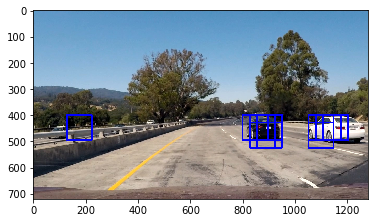

0 cars found


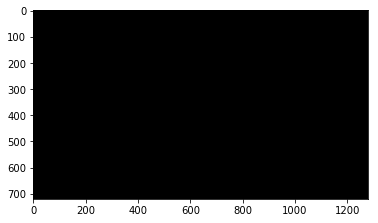

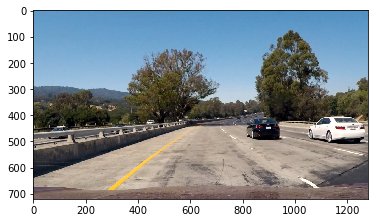

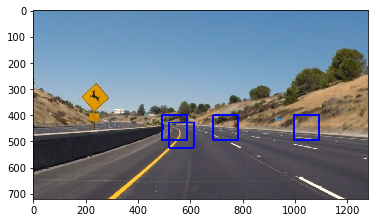

0 cars found


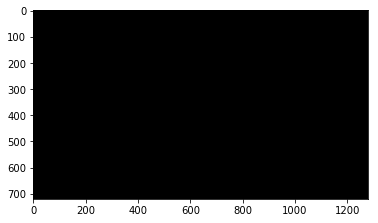

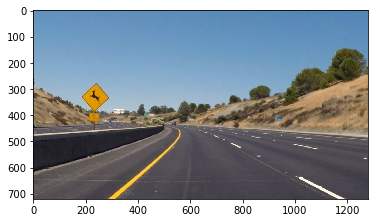

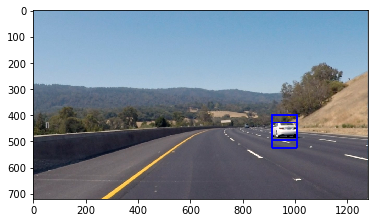

0 cars found


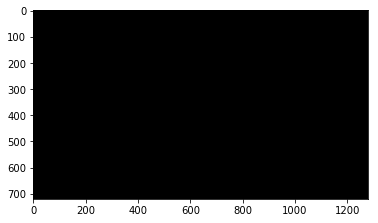

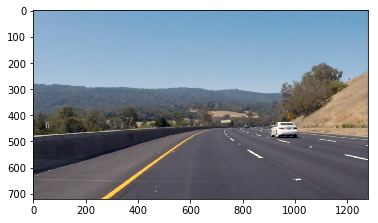

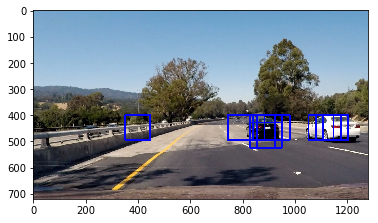

0 cars found


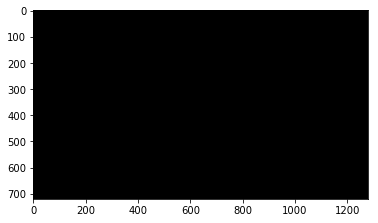

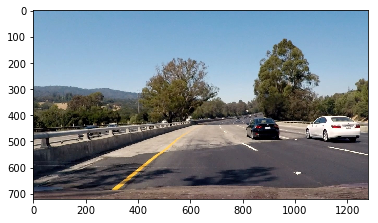

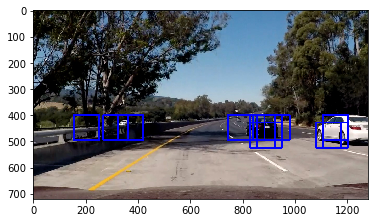

0 cars found


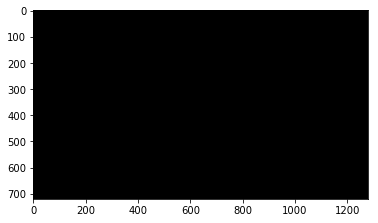

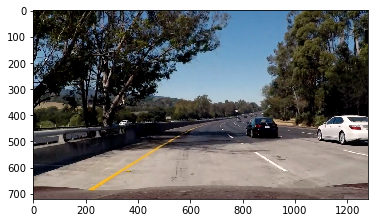

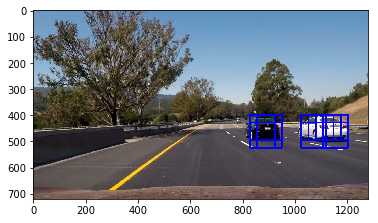

0 cars found


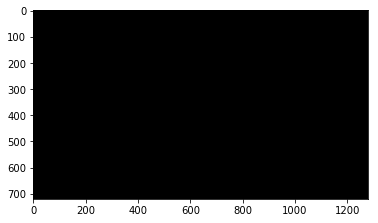

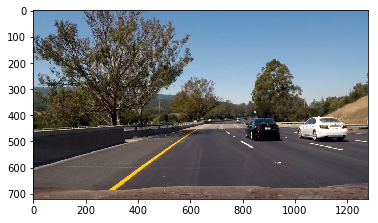

In [15]:
svc = LinearSVC()
X_scaler = StandardScaler()

if use_pretrained:
    with open('model.p', 'rb') as f:
        save_dict = pickle.load(f)
    svc = save_dict['svc']
    X_scaler = save_dict['X_scaler']

    print('Loaded pre-trained model from model.p')
else:
    print('Reading training data and training classifier from scratch')

    with open('data.p', 'rb') as f:
        data = pickle.load(f)
    cars = data['vehicles']
    notcars = data['non_vehicles']
    train(cars, notcars, svc, X_scaler)

    print('Training complete, saving trained model to model.p')

    with open('model.p', 'wb') as f:
        pickle.dump({'svc': svc, 'X_scaler': X_scaler}, f)

# Display predictions on all test_images
imdir = 'test_images'
for image_file in os.listdir(imdir):
    image = mpimg.imread(os.path.join(imdir, image_file))
    draw_image = np.copy(image)

    windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(500, 700),
                    xy_window=(128, 128), xy_overlap=(pct_overlap, pct_overlap))
    windows = slide_window(image, x_start_stop=(100, 1180), y_start_stop=(400, 500),
                    xy_window=(96, 96), xy_overlap=(pct_overlap, pct_overlap))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    plt.imshow(window_img)
    plt.show()

    # Calculate and draw heat map
    heatmap = np.zeros((720, 1280))  # NOTE: Image dimensions hard-coded
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, heatmap_thresh)
    labels = label(heatmap)
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    plt.show()

    # Draw final bounding boxes
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    plt.imshow(draw_img)
    plt.show()

### 6. Annotate video stream

In [17]:
class HotWindows():
    """
    Keep track of n previous hot windows
    Compute cumulative heat map over time

    self.windows is a queue of lists of bounding boxes,
    where the list can be of arbitrary size.
    Each element in the queue represents the list of
    bounding boxes at a particular time frame.
    """
    def __init__(self, n):
        self.n = n
        self.windows = []  # queue implemented as a list

    def add_windows(self, new_windows):
        """
        Push new windows to queue
        Pop from queue if full
        """
        self.windows.append(new_windows)

        q_full = len(self.windows) >= self.n
        if q_full:
            _ = self.windows.pop(0)

    def get_windows(self):
        """
        Concatenate all lists in the queue and return as
        one big list
        """
        out_windows = []
        for window in self.windows:
            out_windows = out_windows + window
        return out_windows

    
# Global variables for moviepy to work
hot_windows = HotWindows(num_frames)
svc = LinearSVC()
X_scaler = StandardScaler()

# MoviePy video annotation will call this function
def annotate_image(image):
    """
    Annotate the input image with detection boxes
    Returns annotated image
    """
    global hot_windows, svc, X_scaler

    draw_image = np.copy(image)

    windows = slide_window(image, x_start_stop=(100, 1180), y_start_stop=(400, 500),
                        xy_window=(96, 96), xy_overlap=(pct_overlap, pct_overlap))

    new_hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    # DEBUG
    window_img = draw_boxes(draw_image, new_hot_windows, color=(0, 0, 255), thick=6)
    #return window_img

    # Add new hot windows to HotWindows queue
    hot_windows.add_windows(new_hot_windows)
    all_hot_windows = hot_windows.get_windows()

    # Calculate and draw heat map
    heatmap = np.zeros((720, 1280))  # NOTE: Image dimensions hard-coded
    heatmap = add_heat(heatmap, all_hot_windows)
    heatmap = apply_threshold(heatmap, heatmap_thresh)
    labels = label(heatmap)

    # Draw final bounding boxes
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img


def annotate_video(input_file, output_file):
    """ Given input_file video, save annotated video to output_file """
    global hot_windows, svc, X_scaler

    with open('model.p', 'rb') as f:
        save_dict = pickle.load(f)
    svc = save_dict['svc']
    X_scaler = save_dict['X_scaler']

    print('Loaded pre-trained model from model.p')

    video = VideoFileClip(input_file)
    annotated_video = video.fl_image(annotate_image)
    annotated_video.write_videofile(output_file, audio=False)

In [18]:
annotate_video('test_video.mp4', 'out.mp4')

Loaded pre-trained model from model.p
[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:09<00:00,  4.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 



In [19]:
annotate_video('project_video.mp4', 'project_out.mp4')

Loaded pre-trained model from model.p
[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:10<00:00,  4.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 

